# Optimization for machine/deep learning: homework 3

### General instructions

Complete the exercises listed below in this Jupyter notebook - leaving all of your code in Python cells in the notebook itself.  Feel free to add any necessary cells.  

Included with the notebook are 

- a custom utilities file called `custom_utils.py` that provides various plotting functionalities (for unit tests to help you debug) as well as some other processing code


- dataset `noisy_sin_sample.csv`

be sure you have these files located in the same directory where you put this notebook!

There is only one exercise in this homework, separated into three parts.

In [10]:
### inport statements
# the next three lines allow you to easily make plots in notebook, and use a nice renderer (for prettier pictures)
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

# import custom utilities
import custom_utils

# import some standard libraries
import numpy as np
import matplotlib.pyplot as plt
import copy   

# include these two statements so that you can work on backend .py files if you like without having to restart the notebook kernel every time you make a change to a .py file
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### <span style="color:#a50e3e;">Exercise 1. </span>   Perform boosting (for regression) by adjusting your coordinate descent code

In this exercise you will adjust your coordinate descent code for minimizing a quadratic, completed in the previous assignment, to perform boost using decision stumps.  You will use the toy dataset plotted by the next Python cell to test your code.

<IPython.core.display.Javascript object>


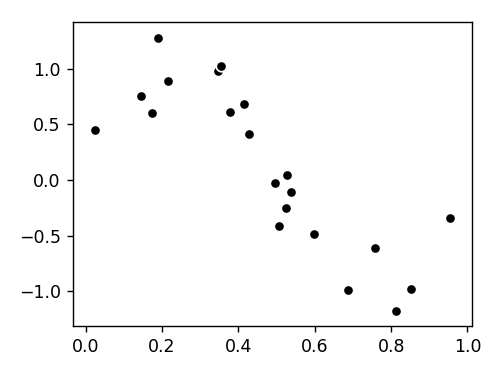

In [11]:
# a linear regression dataset
data = np.loadtxt('noisy_sin_sample.csv',delimiter=',')
x = data[:,0]; x.shape = (len(x),1);
y = data[:,1]; y.shape = (len(y),1);

# scatter plot the input data
fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax.scatter(data[:,0],data[:,1],color = 'k',edgecolor = 'w')
plt.show()

## Part 1

First we need to generate a set of stumps for this dataset - a function ``create_stumps`` for creating these for any given dataset is partially filled out below in the next Python cell - complete this and check that it works using the unit test that comes afterwards.  Hint: looking at the [class notes online](https://jermwatt.github.io/mlrefined/blog_posts/Nonlinear_Supervised_Learning/Part_6_Elements_of_boosting.html) could help.

In [15]:
def create_stumps(x,y):
    '''
    Create stumps tailored to an input dataset (x,y) based on the naive method of creating
    a split point between each pair of successive inputs.  
    
    The input to this function: a dataset (x,y) where the input x has shape 
    (NUMBER OF POINTS by  DIMENSION OF INPUT)
    
    The output of this function is a set of three lists:
    - splits: contains the split points of each stump 
    - levels: contains the corresponding levels of each step
    - dims: records the dimension of the input on which each stump is defined
    '''
    
    # containers for the split points and levels of our stumps, along with container
    # for which dimension the stump is defined along
    splits = []
    levels = []
    dims = []
    
    # important constants: dimension of input N and total number of points P
    N = np.shape(x)[1]              
    P = len(y)

    ### begin outer loop - loop over each dimension of the input
    for n in range(N):
        # make a copy of the n^th dimension of the input data (we will sort after this)
        x_n = copy.deepcopy(x[:,n])
        y_n = copy.deepcopy(y)
        
        # sort x_n and y_n according to ascending order in x_n
        sorted_inds = np.argsort(x_n,axis = 0)
        x_n = x_n[sorted_inds]
        y_n = y_n[sorted_inds]
        for p in range(P - 1):
            ##### YOUR CODE GOES HERE ####
            
            # compute and store split point
            splits.append((x_n[p] + x_n[p+1]) / 2)
            

            # gather output points to left and right of split
            y_left = np.mean(y_n[:p+1])
            y_right = np.mean(y_n[p+1:])

            # compute average on each side, assign to levels
            levels.append(np.array([y_left, y_right]))
            
            
            # remember the dimension this stump is defined along
            dims.append(n)
            
            
    # return items
    return splits,levels,dims

We can then create the complete set of stumps for a dataset using this function, as illustrated below for our test dataset. 

In [16]:
# create stumps for our test dataset using the create_stumps function
splits,levels,dims = create_stumps(x,y)

You can check that you have done this correctly by checking to make sure you match the first five stumps below.

In [17]:
# print out the specifics of an example stump
for i in range(5):
    print ('stump number ' + str(i+1) + ' has split point = ' + str(splits[i]) + ' and levels = ' + str(levels[i]))

stump number 1 has split point = 0.084339 and levels = [ 0.44822     0.09463065]
stump number 2 has split point = 0.159365 and levels = [ 0.59928     0.06011963]
stump number 3 has split point = 0.18194 and levels = [ 0.60044667  0.02997183]
stump number 4 has split point = 0.20265 and levels = [ 0.770035   -0.04348865]
stump number 5 has split point = 0.280225 and levels = [ 0.793746   -0.10174356]


You can also check your split points using the prediction plotter function in our custom utilities.  The cell below plots the original dataset along with the first tuned stump.

<IPython.core.display.Javascript object>


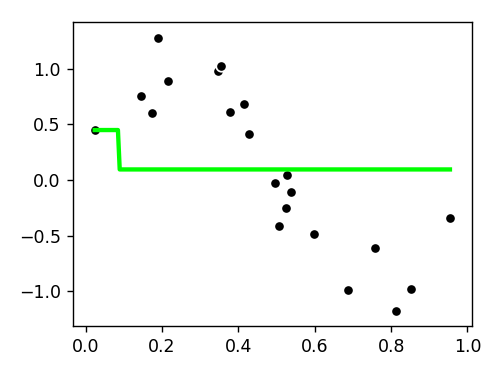

In [18]:
# import plotter
plotter = custom_utils.Visualizer()

# plot data and stump evaluations
w = np.zeros((len(y),1))
w[1] = 1    
plotter.predict_and_plot(x,y,splits,levels,w)

The next cell uses the same plotting function to show the $11^{th}$ stump on the data.

<IPython.core.display.Javascript object>


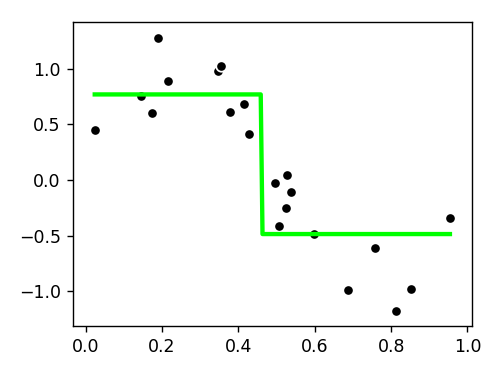

In [19]:
# plot data and stump
w[1] = 0
w[10] = 1
plotter.predict_and_plot(x,y,splits,levels,w)

## Part 2

Say we have a total of $U$ stumps and denote the $u^{th}$ stump as $f_u(x)$.  Our aim is to fit the best subset of $B \leq U$ of these stumps so that when we evaluate an input $x_p$ through a weighted combination of them we approximate its corresponding output $y_p$

\begin{equation}
w_0 + w_1\,f_1\left({x_p}\right) + w_2\,f_2\left({x_p}\right) + \cdots + w_U\,f_U\left({x_p}\right) \approx y_p.
\end{equation}

Wanting this to hold for as many points as possible we then tune these weights by minimizing the corresponding Least Squares cost function one weight at a time.  In class we simply computed and stored each of these function evaluations - denoting 

\begin{equation}
f_{u,p} = f_u\left(x_p\right)
\end{equation}

We then used compact notation to denote every evaluation of the $p^{th}$ point, with a $1$ placed in the first slot, as well as our weights as

\begin{equation}
\mathbf{f}_p = \begin{bmatrix} 1 \\ f_{1,p} \\ f_{2,p} \\ \vdots \\ f_{U,p} \end{bmatrix} \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \mathbf{w} = \begin{bmatrix} w_0^{\,} \\ w_1^{\,} \\ w_2^{\,} \\ \vdots \\ w_U^{\,} \end{bmatrix}
\end{equation}

With this notation we can re-write the desired linear approximation above more succinctly  

\begin{equation}
\mathbf{f}_p^T\mathbf{w}_{\,}^{\,} \approx y_p^{\,}
\end{equation}

Write a Python function ``evaluate_stumps`` that takes in the splits and levels of our stumps as well as a single input $x_p$ and produces its corresponding feature vector $\mathbf{f}_p$.  Part of this is filled in below for you.  You can check that your implementation is correct using the unit test provided afterward.

In [99]:
# stump-tree feats
def evaluate_stumps(splits,levels,x_p):
    # feature vector container
    f_p = []
    
    # append 1 to the top of this for the bias weight w_0
    f_p.append(1)
    # loop over stumps, evaluate x_p in each one
    for i in range(len(splits)):
        ##### YOUR CODE GOES HERE #####
        # get current stump
        split = splits[i]
        level = levels[i]
        
        # check - which side of this split does the pt lie?
        
        val = level[0] if x_p <= split else level[1]
        f_p.append(val)

    # transform into a numpy array
    f_p = np.asarray(f_p)
    f_p.shape = (len(f_p),1)
    return f_p

With your ``evaluate_stumps`` function complete you can check that your implementation is correct by making sure it matches the feature vector of the first input point below.

In [100]:
# create feature vector for input
f_p = evaluate_stumps(splits,levels,x[0])

In [101]:
# the first input's feature 
print ('the feature vector of the first point is')
print (f_p)

the feature vector of the first point is
[[ 1.        ]
 [ 0.09463065]
 [ 0.06011963]
 [ 0.02997183]
 [-0.04348865]
 [-0.10174356]
 [-0.17370247]
 [-0.25943836]
 [-0.326509  ]
 [-0.41033058]
 [-0.48533336]
 [-0.5307319 ]
 [-0.54344433]
 [-0.58025362]
 [-0.66926571]
 [-0.76349667]
 [-0.819458  ]
 [ 0.32039135]
 [ 0.26850628]
 [ 0.19255858]
 [ 0.13413815]]


Run each and every input point through ``evaluate_stumps`` and stack the resulting vectors $\mathbf{f}_1,\,\mathbf{f}_2,\,...,\mathbf{f}_U$ column-wise into a matrix $\mathbf{F}$  This we can think of as our new input data.  This code is provided for you below.

In [23]:
# transform each input and stack into a matrix F
F = []
for p in range(len(x)):
    x_p = x[p]
    f_p = evaluate_stumps(splits,levels,x_p)
    F.append(f_p)
F = np.asarray(F)
F = F[:,:,0].T

We only have one step left before adjusting our alternating descent code to perform boosting: transform our Least Squares cost function here into an explicit quadratic form.  You did this in the previous homework - and the resulting code is copied below as ``transform_least_squares_to_quadratic``.  Pass your data feature matrix $\mathbf{F}$ and corresponding output data $y$ through this function - provided below - to transform the Least Squares cost into an explicit quadratic.

In [24]:
# import utilities
transformer = custom_utils.Visualizer()

# transform input / output pairs to quadratic
a,b,C = transformer.transform_least_squares_to_quadratic(F,y)

## Part 3

Last but not least - adjust the coordinate descent code (you completed in the previous homework) to perform boosting.  A cleaned up version of this code is given below as ``generic_booster`` - it takes in the constants of a quadratic and a number of iterations, and outputs a weight history.  Remember the adjustment that should be made: instead of updating every weight on the inside each outer loop we *only keep* the inner update weight that provides the largest decrease in the cost function.  Several unit tests are provided afterwards so that you can check your work.

In [93]:
def generic_booster(a,b,C,its):
    '''
    Coordinate descent wrapper for general quadratic function. Here
    
    a - a constant
    b - an Nx1 vector
    C - an NxN matrix (symmetric and all nonnegative eigenvalues)
    '''
        
    # settings 
    N = len(b)                         # length of weights
    w = np.zeros((N,1))                # initialization
    w_history = [copy.deepcopy(w)]     # record each weight for plotting
    
    # outer loop - each is a sweep through every variable once
    for i in range(its):
        # inner loop - each is a single variable update
        new_weight = w.copy()
        min_cost = (a + b.T @ w + w.T @ C @ w)
        
        for n in range(N):
            temp_weight = w.copy()
            temp_weight[n] = -(np.dot(C[n,:],w) - C[n,n]*w[n] + 0.5*b[n])/float(C[n,n])
            cost = (a + b.T @ temp_weight + temp_weight.T @ C @ temp_weight)
            
            if cost < min_cost: 
                min_cost = cost
                new_weight = temp_weight
        
        w = new_weight
        w_history.append(w)
        
    return w_history

Several unit tests are provided below so that you can check that you're code is running properly.  Shown first is the cost function plot from 10 iterations.

<IPython.core.display.Javascript object>


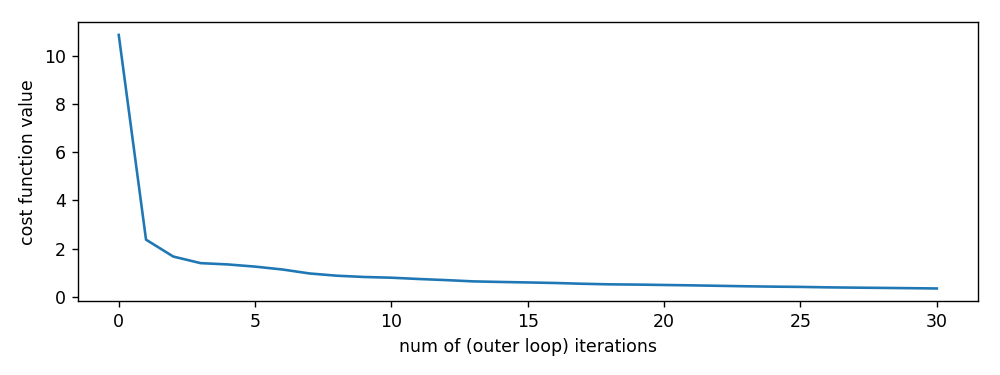

In [94]:
# define quadratic form
g = lambda w: (a + np.dot(b.T,w) + np.dot(np.dot(w.T,C),w))[0]

# run generic booster
w_history = generic_booster(a,b,C,its = 30)

# plot cost function history
demo = custom_utils.Visualizer()
demo.plot_cost(g,w_history)
plt.show()

In the next few cells we show how the model looks at various points in its development.  In particular after the $1^{st}$, $2^{nd}$, $3^{rd}$, and final steps of boosting.  Your code should be able to reproduce these (or at least fits that are quite similar to them).

<IPython.core.display.Javascript object>


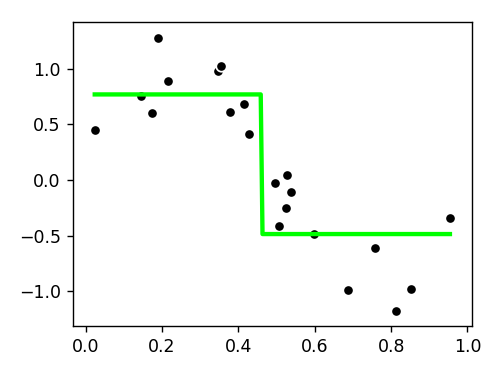

In [95]:
# plot model after first iteration
plotter.predict_and_plot(x,y,splits,levels,w_history[1])

<IPython.core.display.Javascript object>


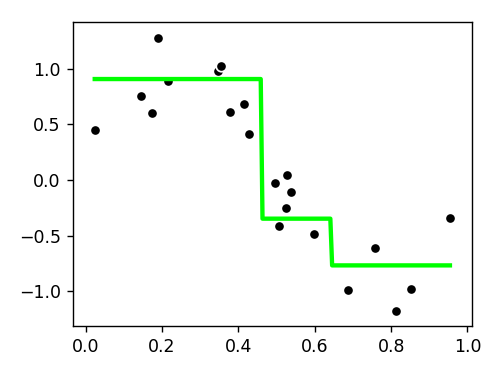

In [96]:
# plot model after second iteration
plotter.predict_and_plot(x,y,splits,levels,w_history[2])

<IPython.core.display.Javascript object>


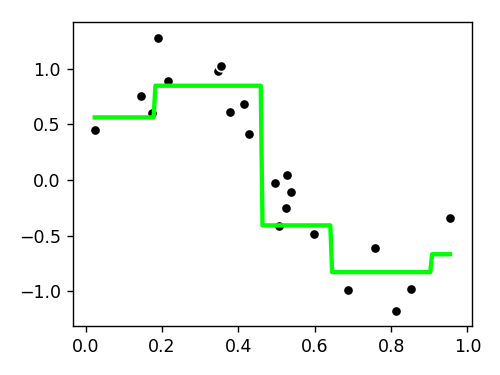

In [97]:
# plot model after second iteration
plotter.predict_and_plot(x,y,splits,levels,w_history[4])

<IPython.core.display.Javascript object>


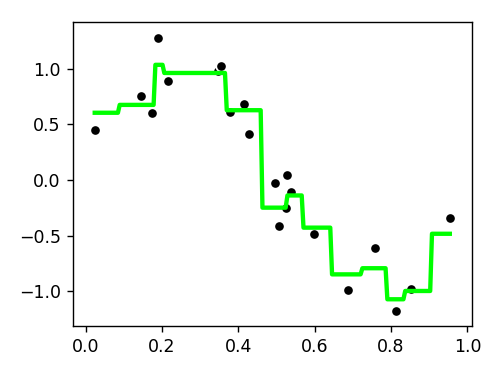

In [98]:
# plot model after second iteration
plotter.predict_and_plot(x,y,splits,levels,w_history[-1])